<a href="https://colab.research.google.com/github/HSE-LAMBDA/mldm-2019/blob/master/day-6/Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoder example

In this example we'll show how an auto-encoder can help when labeled data is limited. Will take the MNIST data keeping only the labels of first 300 examples (out of 60000).

In [0]:
%tensorflow_version 2.x

import tensorflow as tf
tf.__version__

TensorFlow 2.x selected.


'2.0.0-rc2'

Load and preprocess the data (as numpy arrays):

In [0]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = (X_train / 255).astype('float32')
X_test  = (X_test  / 255).astype('float32')

11493376/11490434 [==============================] - 0s 0us/step


Basic autoencoder architecture:

In [0]:
ll = tf.keras.layers
activation = tf.nn.relu

encoder = tf.keras.Sequential([
    ll.Reshape((1, 28, 28), input_shape=(28, 28)),

    ll.Conv2D(16, 3, padding='same', data_format='channels_first', activation=activation),
    ll.MaxPool2D(data_format='channels_first'), # 14x14

    ll.Conv2D(32, 3, padding='same', data_format='channels_first', activation=activation),
    ll.MaxPool2D(data_format='channels_first'), # 7x7

    ll.Conv2D(64, 3, padding='valid', data_format='channels_first', activation=activation), # 5x5
    ll.Conv2D(128, 3, padding='valid', data_format='channels_first', activation=activation), # 3x3
    ll.Conv2D(256, 3, padding='valid', data_format='channels_first', activation=activation), # 1x1
    ll.Conv2D(32, 1, padding='same', data_format='channels_first', activation=activation),

    ll.Reshape((32,))
  ],
  name='encoder')

decoder = tf.keras.Sequential([
    ll.Reshape((32, 1, 1), input_shape=(32,)),

    ll.UpSampling2D(data_format='channels_first'), # 2x2
    ll.Conv2D(256, 3, padding='same', data_format='channels_first', activation=activation),

    ll.UpSampling2D(data_format='channels_first'), # 4x4
    ll.Conv2D(128, 3, padding='same', data_format='channels_first', activation=activation),

    ll.UpSampling2D(data_format='channels_first'), # 8x8
    ll.Conv2D(64, 3, padding='same', data_format='channels_first', activation=activation),

    ll.UpSampling2D(data_format='channels_first'), # 16x16
    ll.Conv2D(32, 3, padding='valid', data_format='channels_first', activation=activation), # 14x14

    ll.UpSampling2D(data_format='channels_first'), # 28x28
    ll.Conv2D(16, 3, padding='same', data_format='channels_first', activation=activation),
    ll.Conv2D(1, 1, padding='valid', data_format='channels_first', activation=tf.nn.relu),

    ll.Reshape((28, 28))
  ],
  name='decoder')

encoder.save('encoder_untrained.h5')

autoencoder = tf.keras.Sequential([
  encoder,
  decoder
])

autoencoder.summary()
autoencoder.compile(optimizer=tf.optimizers.Adam(learning_rate=0.003), loss=tf.keras.losses.MSE)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (None, 32)                400544    
_________________________________________________________________
decoder (Sequential)         (None, 28, 28)            465921    
Total params: 866,465
Trainable params: 866,465
Non-trainable params: 0
_________________________________________________________________


Trainign it on the whole train dataset (note that `X_train` is both inputs and targets for the autoencoder, i.e. we are not using the labels `y_train`):

In [0]:
autoencoder.fit(x=X_train, y=X_train, batch_size=256, epochs=16, validation_data=(X_test, X_test));

Train on 60000 samples, validate on 10000 samples
Epoch 1/16
60000/60000 [==============================] - 16s 267us/sample - loss: 0.0681 - val_loss: 0.0566
Epoch 2/16
60000/60000 [==============================] - 11s 177us/sample - loss: 0.0425 - val_loss: 0.0288
Epoch 3/16
60000/60000 [==============================] - 11s 177us/sample - loss: 0.0256 - val_loss: 0.0205
Epoch 4/16
60000/60000 [==============================] - 11s 178us/sample - loss: 0.0193 - val_loss: 0.0178
Epoch 5/16
60000/60000 [==============================] - 11s 177us/sample - loss: 0.0168 - val_loss: 0.0157
Epoch 6/16
60000/60000 [==============================] - 11s 177us/sample - loss: 0.0152 - val_loss: 0.0139
Epoch 7/16
60000/60000 [==============================] - 11s 176us/sample - loss: 0.0139 - val_loss: 0.0142
Epoch 8/16
60000/60000 [==============================] - 11s 176us/sample - loss: 0.0129 - val_loss: 0.0122
Epoch 9/16
60000/60000 [==============================] - 11s 178us/sample - l

Some plotting code:

In [0]:
import matplotlib.pyplot as plt

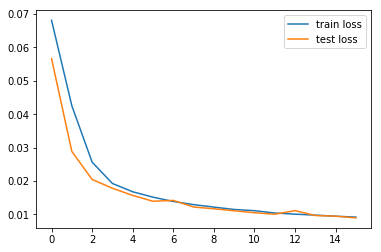

In [0]:
plt.plot(autoencoder.history.history['loss'], label='train loss')
plt.plot(autoencoder.history.history['val_loss'], label='test loss')
plt.legend()
plt.show();

Now we'll use the encoder to train a classifier on its outputs. We don't want to update the encoder's weights anymore:

In [0]:
encoder.trainable = False

In [0]:
classifier = tf.keras.Sequential([
    encoder,
    ll.Dense(10),
  ],
  name='classifier')

classifier.summary()
classifier.compile(optimizer=tf.optimizers.Adam(learning_rate=0.05), loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                   metrics=[tf.metrics.SparseCategoricalAccuracy()])

Model: "classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (None, 32)                400544    
_________________________________________________________________
dense (Dense)                (None, 10)                330       
Total params: 400,874
Trainable params: 330
Non-trainable params: 400,544
_________________________________________________________________


Now let's fit the classifier on first 300 labeled objects:

In [0]:
classifier.fit(x=X_train[:300], y=y_train[:300], batch_size=128, epochs=50, validation_data=(X_test, y_test));

Train on 300 samples, validate on 10000 samples
Epoch 1/50
300/300 [==============================] - 2s 7ms/sample - loss: 2.6811 - sparse_categorical_accuracy: 0.0700 - val_loss: 2.3202 - val_sparse_categorical_accuracy: 0.1127
Epoch 2/50
300/300 [==============================] - 0s 1ms/sample - loss: 2.2586 - sparse_categorical_accuracy: 0.1500 - val_loss: 2.1414 - val_sparse_categorical_accuracy: 0.2438
Epoch 3/50
300/300 [==============================] - 0s 1ms/sample - loss: 1.9659 - sparse_categorical_accuracy: 0.3100 - val_loss: 1.8095 - val_sparse_categorical_accuracy: 0.5189
Epoch 4/50
300/300 [==============================] - 0s 1ms/sample - loss: 1.6987 - sparse_categorical_accuracy: 0.6100 - val_loss: 1.6405 - val_sparse_categorical_accuracy: 0.5515
Epoch 5/50
300/300 [==============================] - 0s 1ms/sample - loss: 1.4962 - sparse_categorical_accuracy: 0.7067 - val_loss: 1.4489 - val_sparse_categorical_accuracy: 0.7649
Epoch 6/50
300/300 [======================

We got test accuracy up to 90% by training on just 300 objects! Note that there is 10000 objects in the test set.

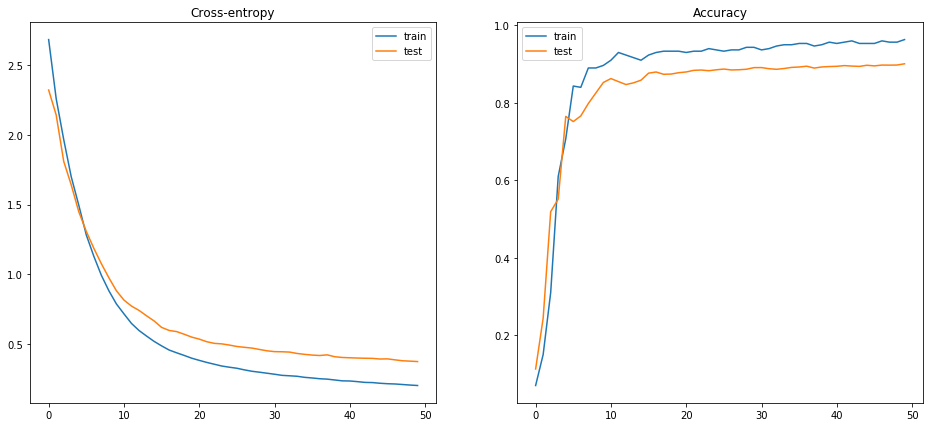

In [0]:
plt.figure(figsize=(16, 7))
plt.subplot(1, 2, 1)
plt.plot(classifier.history.history['loss'], label='train')
plt.plot(classifier.history.history['val_loss'], label='test')
plt.legend()
plt.title('Cross-entropy')

plt.subplot(1, 2, 2)
plt.plot(classifier.history.history['sparse_categorical_accuracy'], label='train')
plt.plot(classifier.history.history['val_sparse_categorical_accuracy'], label='test')
plt.legend()
plt.title('Accuracy')
plt.show();


Now let's imagine we have similar architecture to train from scratch on just 300 objects:

In [0]:
encoder.trainable = True
encoder.load_weights('encoder_untrained.h5')

classifier = tf.keras.Sequential([
  encoder,
  ll.Dense(10),
  ],
  name='classifier')

classifier.summary()
classifier.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                   metrics=[tf.metrics.SparseCategoricalAccuracy()])

Model: "classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (None, 32)                400544    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                330       
Total params: 400,874
Trainable params: 400,874
Non-trainable params: 0
_________________________________________________________________


In [0]:
classifier.fit(x=X_train[:300], y=y_train[:300], batch_size=64, epochs=50, validation_data=(X_test, y_test));

Train on 300 samples, validate on 10000 samples
Epoch 1/50
300/300 [==============================] - 2s 6ms/sample - loss: 3.5724 - sparse_categorical_accuracy: 0.1267 - val_loss: 2.3028 - val_sparse_categorical_accuracy: 0.0980
Epoch 2/50
300/300 [==============================] - 1s 2ms/sample - loss: 2.2978 - sparse_categorical_accuracy: 0.1133 - val_loss: 2.3040 - val_sparse_categorical_accuracy: 0.0980
Epoch 3/50
300/300 [==============================] - 1s 2ms/sample - loss: 2.2957 - sparse_categorical_accuracy: 0.1133 - val_loss: 2.3042 - val_sparse_categorical_accuracy: 0.1010
Epoch 4/50
300/300 [==============================] - 1s 2ms/sample - loss: 2.2898 - sparse_categorical_accuracy: 0.1267 - val_loss: 2.3000 - val_sparse_categorical_accuracy: 0.2522
Epoch 5/50
300/300 [==============================] - 1s 2ms/sample - loss: 2.2671 - sparse_categorical_accuracy: 0.2267 - val_loss: 2.2588 - val_sparse_categorical_accuracy: 0.2473
Epoch 6/50
300/300 [======================

This results in a heavy overfit:

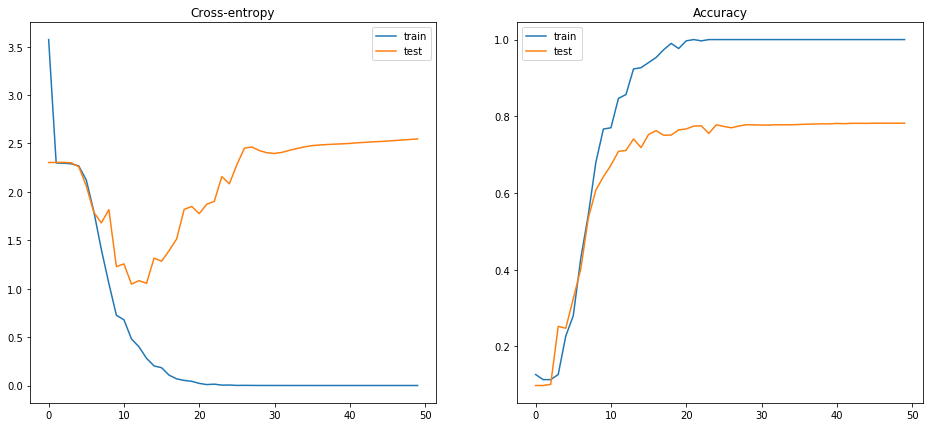

In [0]:
plt.figure(figsize=(16, 7))
plt.subplot(1, 2, 1)
plt.plot(classifier.history.history['loss'], label='train')
plt.plot(classifier.history.history['val_loss'], label='test')
plt.legend()
plt.title('Cross-entropy')

plt.subplot(1, 2, 2)
plt.plot(classifier.history.history['sparse_categorical_accuracy'], label='train')
plt.plot(classifier.history.history['val_sparse_categorical_accuracy'], label='test')
plt.legend()
plt.title('Accuracy')
plt.show();


# Exercise

Try re-writing the code above to train the autoencoder and the classifier simultaneously.